In [21]:
# interpolate [co2] from 47 model levels to 20 OCO2 levels

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [23]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [24]:
# month of the simulation
month  = 12     # 1,2,3, 

In [25]:
if(month >= 10):
    model_file = '2d_ts_satellite.2018' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_2018' + str(month) + '.nc'
else:
    model_file = '2d_ts_satellite.20180' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_20180' + str(month) + '.nc'

In [26]:
# Name and path of inputs and outputs
input_directory = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018/nd51/'
input_file = input_directory + model_file
# corresponding satellite data
satellite_directory = '/geos/u73/msadiq/satellite/oco-2/'

output_file = input_directory + 'interpolated_' + model_file
output_directory = input_directory

In [27]:
# model input
ds_model          = xr.open_dataset(input_file)

levels_model      = ds_model['levels']
surf_press_mod    = ds_model['PEDGE_S_PSURF']
profile_press_mod = surf_press_mod * levels_model # pressure at different levels
record            = ds_model['record'].values

In [28]:
# satellite input
ds_satellite = xr.open_dataset(satellite_directory + satellite_file)
levels_sat = ds_satellite['levels']
surf_press_sat = ds_satellite['psurf']       # not really needed
profile_press_sat = ds_satellite['pressure'] # pressure profile of different levels
print(profile_press_sat[9442].values)
# multi_pressure = surf_pressure * levels_sat
# multi_pressure[47007,:].values            # same as pressure profile

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


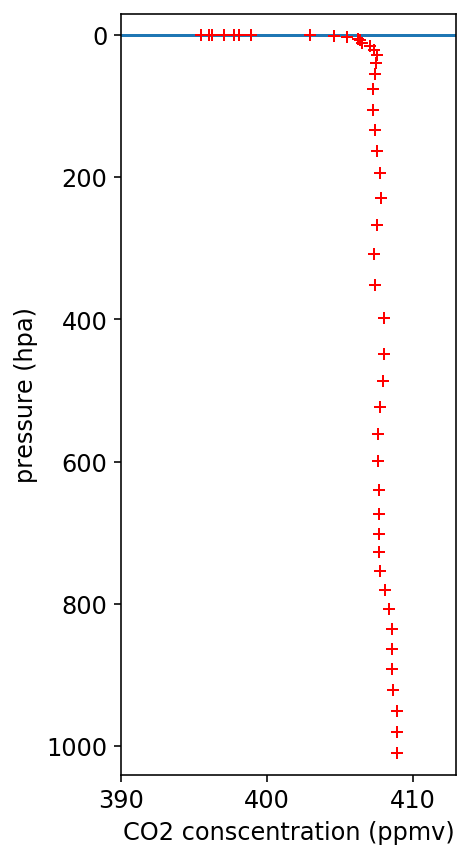

In [29]:
# pick one location where we have data from OCO2 
# and show difference in levels
irecord = 9442
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][47007,:] # 47 levels

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+') # co2 unit is still ppbv here
ax.set_ylim(1040,-30)  # reverse y axis
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hpa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

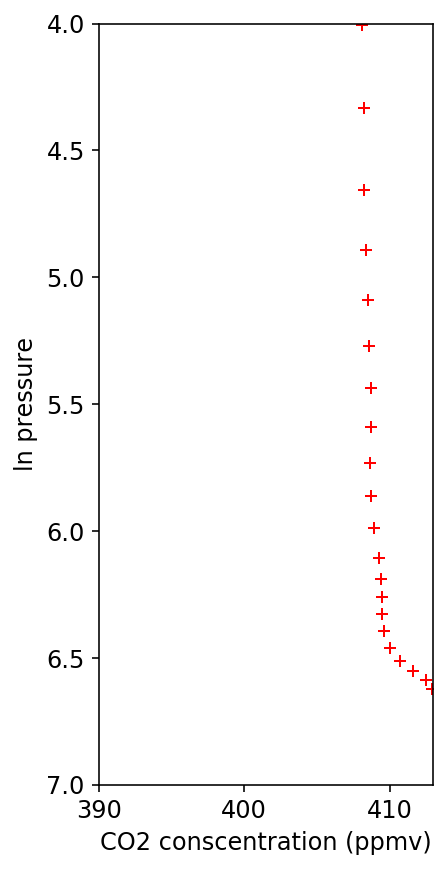

In [30]:
# pick one location where we have data from OCO2
# show in ln pressure coordinate
# linear interpolation using ln(pressure)
# show results of interpolation
y_press_mod = np.log(profile_press_mod[irecord,:].values)
y_press_sat = np.log(profile_press_sat[irecord].values)
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

interpolated_co2 = np.interp(x = y_press_sat, xp = np.flip(y_press_mod), fp = np.flip(x_co2)) # linear inte

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(7,4)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('ln pressure')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

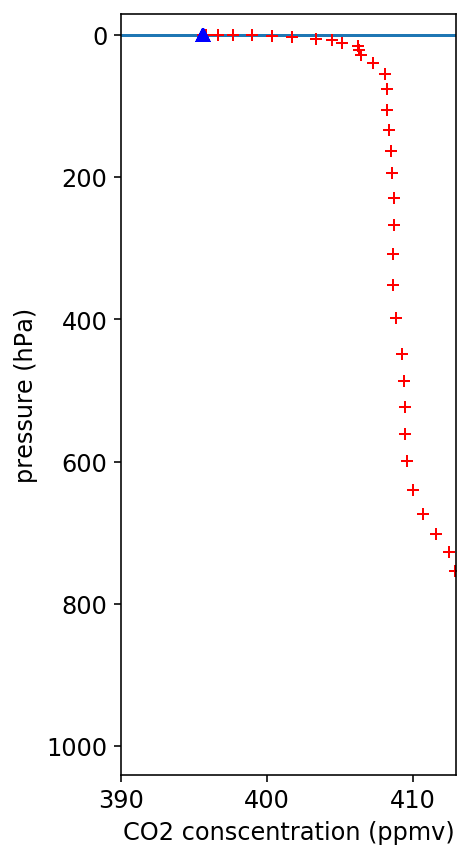

In [31]:
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(1040,-30)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hPa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()
fig.savefig(output_directory + 'interpolation.png', bbox_inches='tight')

In [32]:
# new dataset to store interpolated co2 from model
interpolated = ds_satellite['pressure'].to_dataset()
interpolated

<xarray.Dataset>
Dimensions:   (levels: 20, record: 406224)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels    (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0
Data variables:
    pressure  (record, levels) float32 ...

In [33]:
varnames = list(ds_model.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
nvar = len(varnames)  # how many elements in the list?
needed_vars = np.append(varnames[0], varnames[7:29])
needed_vars

array(['SpeciesConc_CO2'], dtype='<U32')

In [34]:
# temporary 2d dataarray to save interpolated data
tmp = xr.DataArray(data = 0,
                   dims=('record', 'levels'),
                   coords=[record, ds_satellite.coords['levels']])
tmp = tmp.astype(dtype = 'float32')
tmp

<xarray.DataArray (record: 406224, levels: 20)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels   (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0

In [35]:
for ivar in needed_vars:
    interpolated[ivar] = tmp.copy()
interpolated

<xarray.Dataset>
Dimensions:          (levels: 20, record: 406224)
Coordinates:
  * record           (record) int64 0 1 2 3 4 ... 406220 406221 406222 406223
  * levels           (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure         (record, levels) float32 ...
    SpeciesConc_CO2  (record, levels) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [36]:
# interpolation
for irecord in record:
    if profile_press_sat[irecord][19] != 0.:   # if measurement is non-zero, i.e. exists
        for ivar in needed_vars:
            before         = ds_model[ivar] # get co2 before interpolation
            x_co2          = before[irecord,:].values # a co2 profile
            pres_before    = np.log(profile_press_mod[irecord].values) # log space
            pres_after     = np.log(profile_press_sat[irecord])
            # linear interpolation            
            interpolated[ivar][irecord,:] = np.interp(x  = pres_after, 
                                                      xp = np.flip(pres_before), # increasing order
                                                      fp = np.flip(x_co2)) 
        print(irecord)

866
1161
1617
1656
1657
1894
1904
2047
2057
2136
2181
2191
2201
2280
2325
2334
2335
2404
2424
2478
2548
2597
2661
2691
2711
2740
2805
2815
2835
2855
2874
2899
2949
2959
2979
2999
3043
3063
3083
3093
3122
3172
3187
3236
3266
3331
3351
3380
3459
3475
3494
3524
3534
3554
3603
3618
3619
3638
3658
3678
3697
3698
3717
3747
3762
3782
3802
3821
3822
3841
3861
3916
3926
3946
3955
3965
3985
4005
4034
4060
4070
4109
4149
4178
4203
4204
4224
4233
4243
4253
4292
4293
4312
4322
4347
4357
4377
4387
4397
4447
4456
4491
4501
4531
4600
4625
4635
4645
4674
4675
4684
4744
4753
4769
4779
4789
4818
4828
4848
4868
4888
4897
4913
4922
4923
4932
4933
4972
4992
5012
5022
5031
5056
5057
5066
5076
5136
5155
5166
5200
5210
5220
5260
5310
5344
5354
5364
5423
5443
5454
5488
5498
5508
5547
5567
5587
5598
5616
5632
5642
5652
5681
5691
5711
5731
5776
5785
5786
5795
5825
5855
5919
5929
5939
5969
5979
6063
6073
6083
6113
6207
6217
6227
6256
6257
6351
6361
6371
6390
6400
6430
6469
6470
6495
6505
6514
6515
6534
6544
6574
6

81492
81537
81548
81549
81557
81567
81577
81656
81661
81681
81692
81711
81720
81721
81799
81805
81825
81836
81933
81943
81949
81979
81980
81988
82028
82077
82092
82102
82123
82142
82171
82172
82221
82236
82267
82276
82286
82315
82365
82380
82411
82420
82429
82430
82439
82479
82508
82509
82524
82534
82563
82603
82623
82652
82662
82668
82677
82678
82707
82717
82727
82747
82766
82767
82777
82786
82796
82811
82851
82861
82871
82890
82891
82910
82921
82930
82940
82995
83005
83015
83025
83034
83054
83065
83074
83084
83119
83139
83148
83149
83169
83178
83198
83209
83218
83228
83253
83263
83282
83292
83302
83313
83322
83342
83352
83353
83362
83381
83387
83397
83436
83457
83486
83496
83530
83531
83540
83550
83601
83610
83629
83640
83674
83684
83694
83724
83744
83745
83753
83754
83773
83784
83793
83818
83828
83838
83858
83868
83897
83917
83937
83962
83972
83982
84011
84021
84032
84061
84081
84106
84126
84155
84165
84176
84185
84205
84225
84234
84250
84260
84269
84299
84309
84329
84348
84349
8437

126217
126218
126226
126237
126246
126257
126276
126285
126286
126301
126330
126350
126361
126370
126390
126401
126419
126429
126444
126465
126494
126505
126545
126563
126588
126598
126609
126638
126649
126669
126732
126742
126753
126781
126793
126812
126832
126897
126925
126936
126937
126956
127029
127041
127080
127100
127120
127173
127184
127185
127328
127520
127531
127551
127616
127819
127990
128133
132366
132367
132722
132781
132925
133009
133094
133153
133227
133297
133316
133361
133410
133411
133440
133460
133480
133489
133505
133554
133604
133633
133747
133777
133871
133891
133911
133920
133921
133995
134015
134035
134054
134055
134139
134159
134178
134179
134198
134233
134283
134302
134303
134322
134342
134398
134417
134446
134466
134486
134542
134590
134610
134630
134685
134694
134734
134754
134773
134829
134838
134858
134897
134917
134942
134952
134962
134973
134982
135002
135041
135061
135081
135096
135106
135117
135126
135145
135185
135224
135240
135250
135260
135261
135279

174444
174445
174454
174465
174474
174494
174505
174524
174533
174539
174559
174588
174598
174609
174618
174638
174649
174667
174677
174702
174703
174732
174742
174753
174762
174792
174801
174811
174821
174846
174876
174886
174897
174905
174906
174925
174936
174945
174955
174990
175020
175030
175040
175049
175069
175080
175089
175099
175134
175164
175173
175193
175213
175224
175233
175243
175278
175297
175307
175317
175337
175357
175368
175377
175386
175387
175421
175422
175451
175461
175481
175585
175595
175605
175616
175625
175674
175684
175709
175729
175749
175759
175760
175818
175828
175853
175883
175892
175893
175903
175971
175972
175987
175997
176026
176027
176036
176115
176131
176141
176170
176180
176200
176259
176275
176284
176285
176314
176324
176344
176393
176403
176418
176428
176458
176468
176479
176488
176537
176572
176602
176612
176631
176681
176706
176716
176746
176756
176775
176850
176860
176889
176899
176919
176994
177043
177137
177138
177147
177177
177187
177198
177207

217409
217418
217438
217453
217513
217514
217533
217542
217553
217562
217581
217582
217591
217597
217607
217626
217657
217686
217697
217706
217725
217735
217740
217741
217790
217801
217810
217821
217829
217830
217869
217884
217934
217945
217953
217965
217973
218013
218028
218038
218058
218077
218078
218089
218108
218109
218117
218157
218172
218182
218193
218202
218221
218232
218233
218261
218272
218280
218281
218315
218316
218325
218326
218337
218365
218376
218396
218404
218405
218416
218424
218454
218459
218469
218520
218540
218548
218560
218568
218613
218633
218664
218672
218692
218776
218847
218920
218951
218991
219135
219199
219259
219286
219343
219487
219630
219861
223916
223961
224104
224391
224509
224574
224642
224652
224717
224786
224796
224880
225073
225128
225272
225292
225331
225415
225416
225425
225475
225559
225569
225703
225713
225801
225817
225847
225857
225945
225990
225991
226000
226030
226050
226089
226125
226134
226144
226174
226194
226248
226269
226278
226317
226337

258125
258144
258145
258209
258221
258288
258365
258432
258575
258576
258595
258719
258883
263250
263260
263393
263536
263680
263799
263817
263818
263823
263961
263966
263967
264046
264085
264105
264110
264130
264160
264189
264190
264248
264303
264407
264447
264516
264551
264591
264640
264660
264670
264685
264695
264705
264784
264813
264823
264829
264838
264888
264927
264928
264967
264982
264992
265022
265031
265032
265051
265071
265101
265111
265126
265147
265155
265156
265175
265195
265215
265235
265245
265270
265299
265378
265413
265453
265463
265483
265522
265597
265627
265666
265685
265731
265740
265741
265750
265810
265829
265855
265884
265894
265963
265973
265998
266018
266028
266058
266077
266078
266142
266202
266221
266232
266241
266286
266316
266336
266345
266365
266376
266385
266395
266404
266430
266469
266480
266489
266509
266520
266529
266539
266548
266564
266574
266603
266613
266624
266633
266653
266663
266664
266682
266692
266708
266717
266718
266747
266757
266768
266777

297518
297538
297558
297589
297597
297609
297617
297681
297682
297701
297761
297825
297904
297916
297969
298060
302411
303285
303375
303498
303642
303746
303889
303890
303969
304033
304112
304113
304132
304157
304177
304197
304216
304217
304256
304276
304321
304341
304360
304400
304419
304524
304563
304588
304608
304628
304707
304752
304772
304831
304851
304896
304916
304955
304975
305059
305203
305262
305282
305297
305298
305307
305327
305347
305367
305406
305426
305441
305471
305510
305550
305585
305615
305635
305654
305694
305713
305714
305729
305758
305759
305778
305798
305818
305838
305857
305883
305902
305922
305942
305962
305981
305982
306001
306016
306017
306046
306066
306086
306105
306106
306125
306145
306170
306190
306210
306229
306230
306249
306269
306289
306304
306314
306353
306354
306413
306432
306433
306448
306458
306497
306517
306537
306557
306576
306592
306602
306632
306641
306661
306701
306720
306736
306745
306746
306776
306785
306864
306889
306920
306929
307023
307033

344552
344571
344601
344606
344616
344636
344656
344715
344760
344780
344839
344859
344904
344924
344983
345022
345048
345067
345068
345127
345157
345166
345176
345271
345290
345301
345310
345335
345414
345434
345464
345479
345519
345538
345558
345578
345589
345607
345608
345623
345662
345663
345682
345702
345742
345751
345767
345797
345806
345826
345846
345885
345895
345911
345930
345950
345990
346029
346044
346054
346074
346085
346094
346114
346133
346134
346173
346183
346188
346198
346238
346277
346317
346327
346332
346342
346362
346382
346421
346476
346486
346525
346526
346565
346620
346630
346669
346709
346764
346773
346774
346813
346853
346917
346948
346957
346996
347046
347051
347061
347101
347140
347190
347195
347205
347245
347284
347339
347349
347369
347388
347428
347483
347512
347532
347552
347563
347572
347656
347676
347696
347706
347707
347765
347800
347820
347831
347850
347859
347909
347914
347944
347974
347994
348052
348058
348088
348118
348127
348138
348147
348167
348186

388042
388071
388115
388116
388135
388146
388155
388166
388175
388186
388214
388224
388259
388290
388299
388310
388319
388330
388358
388383
388403
388443
388454
388462
388473
388502
388527
388538
388586
388597
388606
388617
388671
388682
388710
388741
388750
388761
388789
388815
388826
388854
388893
388894
388905
388925
388958
388969
388970
389017
389037
389049
389113
389181
389246
389257
389265
389305
389325
389344
389401
389409
389448
389488
389612
389643
389787
389832


In [37]:
# variables need not to be interpolated
noneed_interp = ['lat', 'lon', 'date']
for ivar in noneed_interp:
    interpolated[ivar] = ds_model[ivar].copy()

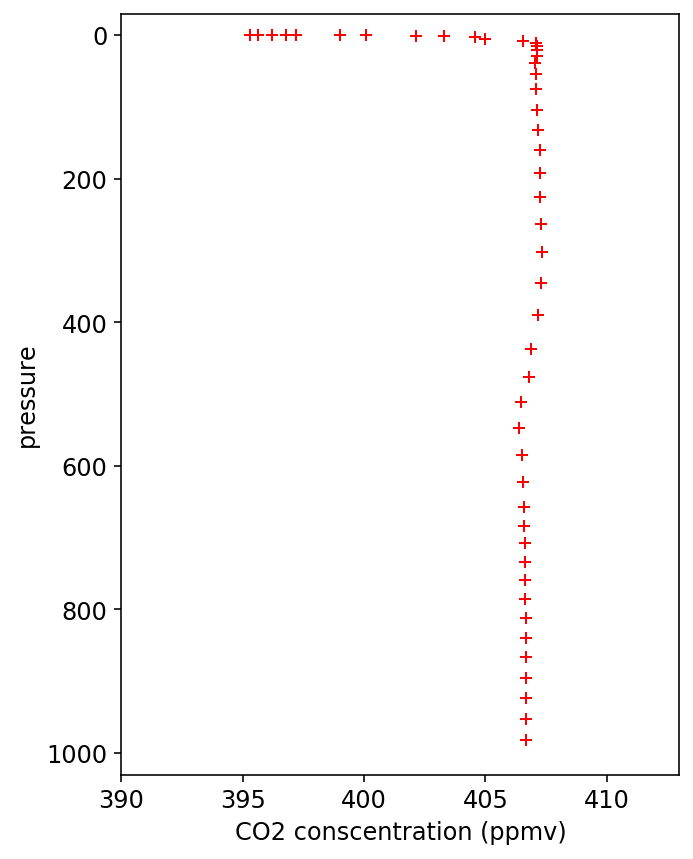

In [38]:
# after interpolation
irecord = 5313
x_co2_after    = interpolated['SpeciesConc_CO2'][irecord,:]
y_press_after  = interpolated['pressure'][irecord,:]

x_co2_before   = ds_model['SpeciesConc_CO2'][irecord,:]
y_press_before = profile_press_mod[irecord]

fig, ax = plt.subplots(figsize=[5,7])

ax.plot(x_co2_after*1e-3, y_press_after, 'b^')
ax.plot(x_co2_before*1e-3, y_press_before, 'r+')
ax.set_ylim(1030,-30)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure')

plt.show()

In [39]:
interpolated.attrs['comment'] = 'interpolated from 47 level model outputs'
interpolated.to_netcdf(output_file)

In [40]:
interpolated

<xarray.Dataset>
Dimensions:          (levels: 20, record: 406224)
Coordinates:
  * record           (record) int64 0 1 2 3 4 ... 406220 406221 406222 406223
  * levels           (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure         (record, levels) float32 ...
    SpeciesConc_CO2  (record, levels) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat              (record) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon              (record) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
    date             (record) datetime64[ns] 2018-12-01 ... 2018-12-31
Attributes:
    comment:  interpolated from 47 level model outputs